In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import xarray as xr

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
WG_5 = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/WGLC/wglc_climatology_05m.nc")
WG_5

<xarray.Dataset>
Dimensions:  (lon: 4320, lat: 2160, time: 12)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
  * time     (time) object 0000-01-01 00:00:00 ... 0000-12-01 00:00:00
Data variables:
    density  (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

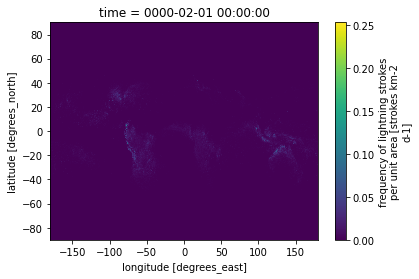

In [ ]:
WG_5.density[1,:,:].plot()

##shapefiles and crops


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install geopandas
!pip install rioxarray

In [ ]:
import rioxarray
from geopandas import read_file as gpd_read_file

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
!pip install importlib-metadata==4.13
!pip install geopandas
!pip install rasterio
!pip install scipy
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shp_peru = gpd.read_file("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/shps/areas naturales del peru/region natural_geogpsperu_JuanPabloSuyoPomalia.shp")
shp_peru.head()

,OBJECTID,GlobalID,Escala,Fuente,Cod_RegNat,Nm_RegNat,SHAPE_Leng,SHAPE_Area,contacto,web,whatsapp,geometry
0,1,{4DB64834-22F3-492A-8461-71DE7B0B6394},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,2,Sierra,87.894629,31.486141,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"MULTIPOLYGON (((-74.72973 -11.61102, -74.72932..."
1,2,{8F2361F2-9CE0-44F5-8210-D3A8DFAB7A41},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,3,Selva,92.589739,62.876535,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"POLYGON ((-69.11407 -14.48779, -69.11434 -14.4..."
2,3,{D2806CDD-429B-4606-A38B-EAB1DFBB7845},0,OFICIO N Â° 287-2016-INEI/DNCE-DECG,1,Costa,75.671063,12.250577,juan.suyo@geogpsperu.com,www.geogpsperu.com,931381206,"MULTIPOLYGON (((-79.80161 -4.48881, -79.80155 ..."


In [ ]:
shp_peru_costa = shp_peru.loc[shp_peru.OBJECTID == 2]

In [ ]:
shp_peru_costa.total_bounds

array([-79.92019336, -17.98791902, -68.81421685,  -4.43347792])

In [ ]:
shp_peru_costa.geometry

0    MULTIPOLYGON (((-74.72973 -11.61102, -74.72932...
Name: geometry, dtype: geometry

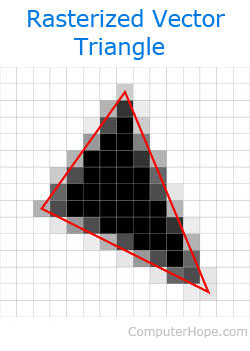

In [ ]:
def xr_crop(shp_i, netcdf_i):
  
  # get box
  #crop hjace un corte en el cuadrante como un where
  box_i = shp_i.total_bounds# Array of coordinates (latitude and longitude)
  
  # crop based on box
  crop_netcdf_i = netcdf_i.where((netcdf_i["longitude"] > box_i[0]) & # min lon
                                 (netcdf_i["longitude"] < box_i[2]) & # max lon
                                 (netcdf_i["latitude"] > box_i[1]) & # min lat
                                 (netcdf_i["latitude"] < box_i[3]), # max lat
                                 drop = True) #delete remain area
  
  return crop_netcdf_i

def xr_shp_to_grid(shp_i, netcdf_array):
  #conversion de shpafile a un  dato grillado 
  # get real box
  shp_i_geometry = shp_i.geometry
  # adding crs #creating xarray dataset
  mask = netcdf_array.rio.set_crs(shp_i.crs)
  # "rasterizing"
  #se denomina como rasterización, se hace un clip para un shp (geometry) determinado
  mask = mask.rio.clip(shp_i_geometry, drop = True)
  # making "True/False" values
  #coinciden los puntos de grilla con los datos del punto de grilla
  mask.values[~np.isnan(mask.values)] = 1 #creo que se cambia de los valores que tienen valores por uno 
  #0 son los que no coincida con los grilla
  #1 preserva los puntos de pixles de cada uno de los puntos
  return mask.drop(["time"]) #se quita el time y el spatial_ref
#xrcrop :: como el where te hace un corte de un cuadrado
#xr_mask :: corte en base del poligono

#netcdf_i ->dato grillado
#shp_i -> shapefile
#grid mask -> mask
def xr_mask(grid_mask, netcdf_i):
  # masking
  #se hace un crop en base al mask gr
  mask_netcdf_i = netcdf_i.where(grid_mask == True)

  return mask_netcdf_i

In [ ]:
#def. coordinates in order to match with crop function
# WG_5=WG_5.rename({"lon":"longitude","lat":"latitude"})

ValueError: ignored

In [ ]:
WG_5.density.isel(time=0)

<xarray.DataArray 'density' (latitude: 2160, longitude: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * latitude   (latitude) float64 -89.96 -89.88 -89.79 ... 89.79 89.88 89.96
    time       object 0000-01-01 00:00:00
Attributes:
    long_name:  frequency of lightning strokes per unit area
    units:      strokes km-2 d-1

cls la diferencia entre isel time= 0  y de [0,:,:]

In [ ]:
WG_5["time"]=np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
WG_5.density.isel(time=0)

<xarray.DataArray 'density' (latitude: 2160, longitude: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * latitude   (latitude) float64 -89.96 -89.88 -89.79 ... 89.79 89.88 89.96
    time       int64 1
Attributes:
    long_name:  frequency of lightning strokes per unit area
    units:      strokes km-2 d-1

In [ ]:
#set crs --- set cordenadas geograficas
WG_5.rio.set_crs(shp_peru_costa.crs)
WG_5CRP=xr_crop(shp_i=shp_peru_costa,netcdf_i=WG_5)
#shape to grid
WG_5_grid=xr_shp_to_grid(shp_i = shp_peru_costa, netcdf_array = WG_5.density.isel(time=0))
#make a mask
WG_5MASK=xr_mask(grid_mask=WG_5_grid, netcdf_i=WG_5CRP)


In [ ]:
WG_5MASK

<xarray.Dataset>
Dimensions:      (time: 12, latitude: 163, longitude: 133)
Coordinates:
  * longitude    (longitude) float64 -79.88 -79.79 -79.71 ... -68.96 -68.88
  * latitude     (latitude) float64 -17.96 -17.88 -17.79 ... -4.542 -4.458
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 0
Data variables:
    density      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

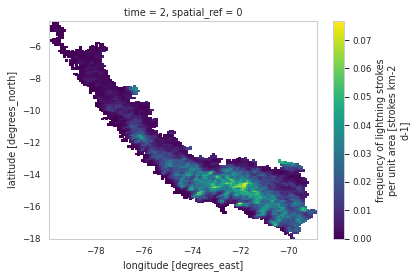

In [ ]:
WG_5MASK.density[1,:,:].plot()

###define piscop and crop

In [ ]:
CC = xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/CC.nc")
CC

<xarray.Dataset>
Dimensions:    (longitude: 1422, latitude: 1982, z: 12)
Coordinates:
  * longitude  (longitude) float64 -81.4 -81.39 -81.38 ... -67.21 -67.2 -67.19
  * latitude   (latitude) float64 1.22 1.21 1.2 1.19 ... -18.57 -18.58 -18.59
  * z          (z) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    crs        int32 ...
    variable   (z, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [ ]:
CC=CC.rename({"z": "time"})

In [ ]:
CC.isel(time=1)

<xarray.Dataset>
Dimensions:    (longitude: 1422, latitude: 1982)
Coordinates:
  * longitude  (longitude) float64 -81.4 -81.39 -81.38 ... -67.21 -67.2 -67.19
  * latitude   (latitude) float64 1.22 1.21 1.2 1.19 ... -18.57 -18.58 -18.59
    time       int32 2
Data variables:
    crs        int32 ...
    variable   (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [ ]:
CC=CC.rio.set_crs(shp_peru_costa.crs)
CC

<xarray.Dataset>
Dimensions:    (longitude: 1422, latitude: 1982, time: 12)
Coordinates:
  * longitude  (longitude) float64 -81.4 -81.39 -81.38 ... -67.21 -67.2 -67.19
  * latitude   (latitude) float64 1.22 1.21 1.2 1.19 ... -18.57 -18.58 -18.59
  * time       (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    crs        int32 ...
    variable   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.3-13)
    date:         2021-06-17 23:13:15

In [ ]:
CC.variable.isel(time=1)

<xarray.DataArray 'variable' (latitude: 1982, longitude: 1422)>
[2818404 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -81.4 -81.39 -81.38 ... -67.21 -67.2 -67.19
  * latitude   (latitude) float64 1.22 1.21 1.2 1.19 ... -18.57 -18.58 -18.59
    time       int32 2
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=...
    min:           [20.69000053 17.70000076 10.46000004  7.05000019  1.909999...
    max:           [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]

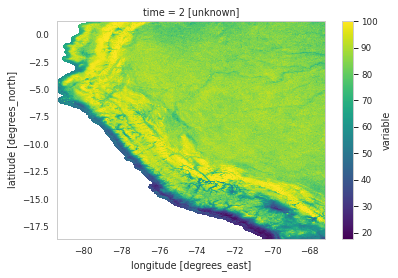

In [ ]:
CC.variable[1,:,:].plot()

In [ ]:
#set crs --- set cordenadas geograficas

# PISCOp_monthly.rio.set_crs(shp_peru_costa.crs)
CC_croped=xr_crop(shp_i=shp_peru_costa,netcdf_i=CC)
#shape to grid
CC_grid=xr_shp_to_grid(shp_i = shp_peru_costa, netcdf_array = CC.variable.isel(time=1))
#make a mask
CC_MASK=xr_mask(grid_mask=CC_grid, netcdf_i=CC_croped)


In [ ]:
CC_MASK.variable[1,:,:]

<xarray.DataArray 'variable' (latitude: 1355, longitude: 1111)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    crs        int64 0
  * longitude  (longitude) float64 -79.92 -79.91 -79.9 ... -68.84 -68.83 -68.82
  * latitude   (latitude) float64 -4.44 -4.45 -4.46 ... -17.96 -17.97 -17.98
    time       int32 2
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=...
    min:           [20.69000053 17.70000076 10.46000004  7.05000019  1.909999...
    max:           [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]

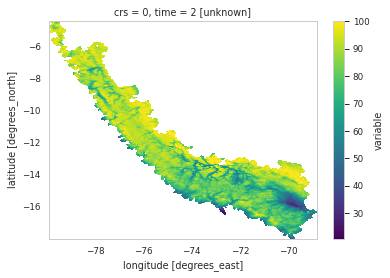

In [ ]:
CC_MASK.variable[1,:,:].plot()

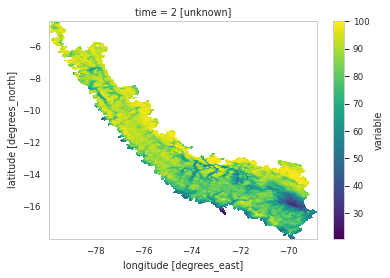

In [ ]:
CC_MASK_wcrs=CC_MASK.drop_vars("crs")
CC_MASK_wcrs.variable[1,:,:].plot()

In [ ]:
# CC_MASK_wcrs["time"]=pd.date_range("1981-01-01", freq='D',periods=13149)

In [ ]:
PISCOp= xr.open_dataset("/content/drive/MyDrive/TRABAJO TÉCNICAS 2/DATOS T[ECNICAS 2/Copy of PISCOp.nc",decode_times=False)

In [ ]:
PISCOp

<xarray.Dataset>
Dimensions:  (T: 13149, Y: 198, X: 133)
Coordinates:
  * T        (T) float32 7.672e+03 7.672e+03 7.674e+03 ... 2.082e+04 2.082e+04
  * Y        (Y) float32 0.95 0.85 0.75 0.65 ... -18.45 -18.55 -18.65 -18.75
  * X        (X) float32 -81.25 -81.15 -81.05 -80.95 ... -68.25 -68.15 -68.05
Data variables:
    Prec     (T, Y, X) float32 ...

In [ ]:
PISCOp=PISCOp.rename({"X": "longitude", "Y": "latitude", "T": "time"})

In [ ]:
PISCOp["time"]=pd.date_range("1981-01-01", freq='D',periods=13149)

In [ ]:
PISCOp

<xarray.Dataset>
Dimensions:    (time: 13149, latitude: 198, longitude: 133)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2016-12-31
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
Data variables:
    Prec       (time, latitude, longitude) float32 ...

In [ ]:
piscop_m=PISCOp.resample(time="1M", skipna=True).sum(dim="time")

In [ ]:
piscop_m=piscop_m.Prec.groupby(piscop_m.time.dt.month).mean(dim="time")

In [ ]:
piscop_m

<xarray.DataArray 'Prec' (month: 12, latitude: 198, longitude: 133)>
array([[[  0.       ,   0.       ,   0.       , ..., 250.02522  ,
         182.7587   , 178.41618  ],
        [  0.       ,   0.       ,   0.       , ..., 274.86935  ,
         214.97586  , 208.87346  ],
        [  0.       ,   0.       ,   0.       , ..., 311.66937  ,
         261.0767   , 238.50163  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  99.78298  ,
          99.7469   , 100.636314 ],
        [  0.       ,   0.       ,   0.       , ..., 105.487114 ,
         105.49649  ,  99.21408  ],
        [  0.       ,   0.       ,   0.       , ...,  96.623215 ,
          89.158516 ,  83.22309  ]],

       [[  0.       ,   0.       ,   0.       , ..., 247.55894  ,
         199.23326  , 194.2985   ],
        [  0.       ,   0.       ,   0.       , ..., 266.94333  ,
         221.90775  , 230.80647  ],
        [  0.       ,   0.       ,   0.       , ..., 292.84875  ,
         249.47087  , 238.73138  ],
...
        [  0.       ,   0.       ,   0.       , ...,   1.8384433,
           1.9869035,   2.2168884],
        [  0.       ,   0.       ,   0.       , ...,   2.0083284,
           2.208728 ,   4.9719405],
        [  0.       ,   0.       ,   0.       , ...,   4.856501 ,
           5.5243435,   5.5275464]],

       [[  0.       ,   0.       ,   0.       , ..., 247.40994  ,
         398.2579   , 525.47864  ],
        [  0.       ,   0.       ,   0.       , ..., 278.8407   ,
         367.33994  , 424.12216  ],
        [  0.       ,   0.       ,   0.       , ..., 286.79596  ,
         304.91174  , 287.64905  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  28.129019 ,
          22.419977 ,  23.805998 ],
        [  0.       ,   0.       ,   0.       , ...,  20.320295 ,
          20.136827 ,  26.310995 ],
        [  0.       ,   0.       ,   0.       , ...,  22.036446 ,
          24.80561  ,  29.898746 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
PISCOp.Prec.groupby(PISCOp.time.dt.month)

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [ ]:
PISCOp_monthlys3=PISCOp.Prec.groupby(PISCOp.time.dt.month).sum(dim="time")

In [ ]:
PISCOp_monthlys3

<xarray.DataArray 'Prec' (month: 12, latitude: 198, longitude: 133)>
array([[[    0.      ,     0.      ,     0.      , ...,  9000.905   ,
          6579.3125  ,  6422.9824  ],
        [    0.      ,     0.      ,     0.      , ...,  9895.302   ,
          7739.134   ,  7519.446   ],
        [    0.      ,     0.      ,     0.      , ..., 11220.089   ,
          9398.762   ,  8586.057   ],
        ...,
        [    0.      ,     0.      ,     0.      , ...,  3592.1882  ,
          3590.8872  ,  3622.9062  ],
        [    0.      ,     0.      ,     0.      , ...,  3797.5356  ,
          3797.8745  ,  3571.705   ],
        [    0.      ,     0.      ,     0.      , ...,  3478.4346  ,
          3209.7063  ,  2996.0315  ]],

       [[    0.      ,     0.      ,     0.      , ...,  8912.11    ,
          7172.398   ,  6994.7437  ],
        [    0.      ,     0.      ,     0.      , ...,  9609.965   ,
          7988.6763  ,  8309.028   ],
        [    0.      ,     0.      ,     0.      , ..., 10542.549   ,
          8980.954   ,  8594.328   ],
...
        [    0.      ,     0.      ,     0.      , ...,    66.18397 ,
            71.52855 ,    79.808014],
        [    0.      ,     0.      ,     0.      , ...,    72.29984 ,
            79.514206,   178.98994 ],
        [    0.      ,     0.      ,     0.      , ...,   174.83414 ,
           198.87646 ,   198.9916  ]],

       [[    0.      ,     0.      ,     0.      , ...,  8906.757   ,
         14337.283   , 18917.23    ],
        [    0.      ,     0.      ,     0.      , ..., 10038.271   ,
         13224.232   , 15268.409   ],
        [    0.      ,     0.      ,     0.      , ..., 10324.65    ,
         10976.831   , 10355.356   ],
        ...,
        [    0.      ,     0.      ,     0.      , ...,  1012.64435 ,
           807.1197  ,   857.01624 ],
        [    0.      ,     0.      ,     0.      , ...,   731.531   ,
           724.9257  ,   947.1956  ],
        [    0.      ,     0.      ,     0.      , ...,   793.3114  ,
           893.0014  ,  1076.3553  ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
piscop_m

<xarray.DataArray 'Prec' (month: 12, latitude: 198, longitude: 133)>
array([[[  0.       ,   0.       ,   0.       , ..., 250.02522  ,
         182.7587   , 178.41618  ],
        [  0.       ,   0.       ,   0.       , ..., 274.86935  ,
         214.97586  , 208.87346  ],
        [  0.       ,   0.       ,   0.       , ..., 311.66937  ,
         261.0767   , 238.50163  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  99.78298  ,
          99.7469   , 100.636314 ],
        [  0.       ,   0.       ,   0.       , ..., 105.487114 ,
         105.49649  ,  99.21408  ],
        [  0.       ,   0.       ,   0.       , ...,  96.623215 ,
          89.158516 ,  83.22309  ]],

       [[  0.       ,   0.       ,   0.       , ..., 247.55894  ,
         199.23326  , 194.2985   ],
        [  0.       ,   0.       ,   0.       , ..., 266.94333  ,
         221.90775  , 230.80647  ],
        [  0.       ,   0.       ,   0.       , ..., 292.84875  ,
         249.47087  , 238.73138  ],
...
        [  0.       ,   0.       ,   0.       , ...,   1.8384433,
           1.9869035,   2.2168884],
        [  0.       ,   0.       ,   0.       , ...,   2.0083284,
           2.208728 ,   4.9719405],
        [  0.       ,   0.       ,   0.       , ...,   4.856501 ,
           5.5243435,   5.5275464]],

       [[  0.       ,   0.       ,   0.       , ..., 247.40994  ,
         398.2579   , 525.47864  ],
        [  0.       ,   0.       ,   0.       , ..., 278.8407   ,
         367.33994  , 424.12216  ],
        [  0.       ,   0.       ,   0.       , ..., 286.79596  ,
         304.91174  , 287.64905  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  28.129019 ,
          22.419977 ,  23.805998 ],
        [  0.       ,   0.       ,   0.       , ...,  20.320295 ,
          20.136827 ,  26.310995 ],
        [  0.       ,   0.       ,   0.       , ...,  22.036446 ,
          24.80561  ,  29.898746 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
PISCOp_monthly

<xarray.DataArray 'Prec' (month: 12, latitude: 198, longitude: 133)>
array([[[  0.       ,   0.       ,   0.       , ..., 250.02522  ,
         182.7587   , 178.41618  ],
        [  0.       ,   0.       ,   0.       , ..., 274.86935  ,
         214.97586  , 208.87346  ],
        [  0.       ,   0.       ,   0.       , ..., 311.66937  ,
         261.0767   , 238.50163  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  99.78298  ,
          99.7469   , 100.636314 ],
        [  0.       ,   0.       ,   0.       , ..., 105.487114 ,
         105.49649  ,  99.21408  ],
        [  0.       ,   0.       ,   0.       , ...,  96.623215 ,
          89.158516 ,  83.22309  ]],

       [[  0.       ,   0.       ,   0.       , ..., 247.55894  ,
         199.23326  , 194.2985   ],
        [  0.       ,   0.       ,   0.       , ..., 266.94333  ,
         221.90775  , 230.80647  ],
        [  0.       ,   0.       ,   0.       , ..., 292.84875  ,
         249.47087  , 238.73138  ],
...
        [  0.       ,   0.       ,   0.       , ...,   1.8384433,
           1.9869035,   2.2168884],
        [  0.       ,   0.       ,   0.       , ...,   2.0083284,
           2.208728 ,   4.9719405],
        [  0.       ,   0.       ,   0.       , ...,   4.856501 ,
           5.5243435,   5.5275464]],

       [[  0.       ,   0.       ,   0.       , ..., 247.40994  ,
         398.2579   , 525.47864  ],
        [  0.       ,   0.       ,   0.       , ..., 278.8407   ,
         367.33994  , 424.12216  ],
        [  0.       ,   0.       ,   0.       , ..., 286.79596  ,
         304.91174  , 287.64905  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  28.129019 ,
          22.419977 ,  23.805998 ],
        [  0.       ,   0.       ,   0.       , ...,  20.320295 ,
          20.136827 ,  26.310995 ],
        [  0.       ,   0.       ,   0.       , ...,  22.036446 ,
          24.80561  ,  29.898746 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
piscop_m.isel(month=1)

<xarray.DataArray 'Prec' (latitude: 198, longitude: 133)>
array([[  0.      ,   0.      ,   0.      , ..., 247.55894 , 199.23326 ,
        194.2985  ],
       [  0.      ,   0.      ,   0.      , ..., 266.94333 , 221.90775 ,
        230.80647 ],
       [  0.      ,   0.      ,   0.      , ..., 292.84875 , 249.47087 ,
        238.73138 ],
       ...,
       [  0.      ,   0.      ,   0.      , ...,  58.247784,  65.17294 ,
         54.22409 ],
       [  0.      ,   0.      ,   0.      , ...,  61.970444,  78.16092 ,
         65.768814],
       [  0.      ,   0.      ,   0.      , ...,  60.237568,  79.06098 ,
         79.74418 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
    month      int64 2
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
piscop_m=piscop_m.rename({"month":"time"})

In [ ]:
piscop_m

<xarray.DataArray 'Prec' (time: 12, latitude: 198, longitude: 133)>
array([[[  0.       ,   0.       ,   0.       , ..., 250.02522  ,
         182.7587   , 178.41618  ],
        [  0.       ,   0.       ,   0.       , ..., 274.86935  ,
         214.97586  , 208.87346  ],
        [  0.       ,   0.       ,   0.       , ..., 311.66937  ,
         261.0767   , 238.50163  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  99.78298  ,
          99.7469   , 100.636314 ],
        [  0.       ,   0.       ,   0.       , ..., 105.487114 ,
         105.49649  ,  99.21408  ],
        [  0.       ,   0.       ,   0.       , ...,  96.623215 ,
          89.158516 ,  83.22309  ]],

       [[  0.       ,   0.       ,   0.       , ..., 247.55894  ,
         199.23326  , 194.2985   ],
        [  0.       ,   0.       ,   0.       , ..., 266.94333  ,
         221.90775  , 230.80647  ],
        [  0.       ,   0.       ,   0.       , ..., 292.84875  ,
         249.47087  , 238.73138  ],
...
        [  0.       ,   0.       ,   0.       , ...,   1.8384433,
           1.9869035,   2.2168884],
        [  0.       ,   0.       ,   0.       , ...,   2.0083284,
           2.208728 ,   4.9719405],
        [  0.       ,   0.       ,   0.       , ...,   4.856501 ,
           5.5243435,   5.5275464]],

       [[  0.       ,   0.       ,   0.       , ..., 247.40994  ,
         398.2579   , 525.47864  ],
        [  0.       ,   0.       ,   0.       , ..., 278.8407   ,
         367.33994  , 424.12216  ],
        [  0.       ,   0.       ,   0.       , ..., 286.79596  ,
         304.91174  , 287.64905  ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  28.129019 ,
          22.419977 ,  23.805998 ],
        [  0.       ,   0.       ,   0.       , ...,  20.320295 ,
          20.136827 ,  26.310995 ],
        [  0.       ,   0.       ,   0.       , ...,  22.036446 ,
          24.80561  ,  29.898746 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 0.95 0.85 0.75 0.65 ... -18.55 -18.65 -18.75
  * longitude  (longitude) float32 -81.25 -81.15 -81.05 ... -68.25 -68.15 -68.05
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
#set crs --- set cordenadas geograficas
PPM_croped=xr_crop(shp_i=shp_peru_costa,netcdf_i=piscop_m)
#shape to grid
PPM_grid=xr_shp_to_grid(shp_i = shp_peru_costa, netcdf_array = piscop_m.isel(time=1))
#make a mask
PPM_MASK=xr_mask(grid_mask=PPM_grid, netcdf_i=PPM_croped)
PPM_MASK

<xarray.DataArray 'Prec' (time: 12, latitude: 136, longitude: 111)>
array([[[       nan,        nan, 119.94083 , ...,        nan,
                nan,        nan],
        [       nan, 142.40279 , 146.76361 , ...,        nan,
                nan,        nan],
        [       nan, 171.82617 , 174.7499  , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan, 160.5174  , ...,        nan,
                nan,        nan],
        [       nan, 235.46208 , 230.14494 , ...,        nan,
                nan,        nan],
        [       nan, 261.66473 , 267.08884 , ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,  83.37142 , ...,        nan,
                nan,        nan],
        [       nan,  76.769806,  88.895676, ...,        nan,
                nan,        nan],
        [       nan,  94.793724,  95.000084, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * latitude     (latitude) float32 -4.45 -4.55 -4.65 ... -17.75 -17.85 -17.95
  * longitude    (longitude) float32 -79.85 -79.75 -79.65 ... -68.95 -68.85
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 0
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
PPM_MASK_wsr=PPM_MASK.drop_vars("spatial_ref")
PPM_MASK_wsr

<xarray.DataArray 'Prec' (time: 12, latitude: 136, longitude: 111)>
array([[[       nan,        nan, 119.94083 , ...,        nan,
                nan,        nan],
        [       nan, 142.40279 , 146.76361 , ...,        nan,
                nan,        nan],
        [       nan, 171.82617 , 174.7499  , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan, 160.5174  , ...,        nan,
                nan,        nan],
        [       nan, 235.46208 , 230.14494 , ...,        nan,
                nan,        nan],
        [       nan, 261.66473 , 267.08884 , ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,  83.37142 , ...,        nan,
                nan,        nan],
        [       nan,  76.769806,  88.895676, ...,        nan,
                nan,        nan],
        [       nan,  94.793724,  95.000084, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -4.45 -4.55 -4.65 ... -17.75 -17.85 -17.95
  * longitude  (longitude) float32 -79.85 -79.75 -79.65 ... -69.05 -68.95 -68.85
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
PPM_MASK_wsr

<xarray.DataArray 'Prec' (time: 12, latitude: 136, longitude: 111)>
array([[[       nan,        nan, 119.94083 , ...,        nan,
                nan,        nan],
        [       nan, 142.40279 , 146.76361 , ...,        nan,
                nan,        nan],
        [       nan, 171.82617 , 174.7499  , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan, 160.5174  , ...,        nan,
                nan,        nan],
        [       nan, 235.46208 , 230.14494 , ...,        nan,
                nan,        nan],
        [       nan, 261.66473 , 267.08884 , ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,  83.37142 , ...,        nan,
                nan,        nan],
        [       nan,  76.769806,  88.895676, ...,        nan,
                nan,        nan],
        [       nan,  94.793724,  95.000084, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -4.45 -4.55 -4.65 ... -17.75 -17.85 -17.95
  * longitude  (longitude) float32 -79.85 -79.75 -79.65 ... -69.05 -68.95 -68.85
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:       Precipitation
    units:           mm/day
    colormap:        [null 16777215 16777215 16777215 [16777215 3] 14155730 [...
    colorscalename:  precip_colors
    maxncolor:       254
    ncolor:          254
    scale_min:       0.0
    CS:              0

In [ ]:
WG_5MASK_WSR=WG_5MASK.drop_vars("spatial_ref")
WG_5MASK_WSR

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 163, longitude: 133)
Coordinates:
  * longitude  (longitude) float64 -79.88 -79.79 -79.71 ... -69.04 -68.96 -68.88
  * latitude   (latitude) float64 -17.96 -17.88 -17.79 ... -4.625 -4.542 -4.458
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

In [ ]:
WG_5MASK_WSR["time"]=np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
WG_5MASK_WSR

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 163, longitude: 133)
Coordinates:
  * longitude  (longitude) float64 -79.88 -79.79 -79.71 ... -69.04 -68.96 -68.88
  * latitude   (latitude) float64 -17.96 -17.88 -17.79 ... -4.625 -4.542 -4.458
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

In [ ]:
#interpolate CC_MASK with PPM_MASK
CC_MASK_interpolated=CC_MASK_wcrs.variable.interp_like(PPM_MASK,method="nearest")
CC_MASK_interpolated=CC_MASK_interpolated.to_dataset()

In [ ]:
CC_MASK_interpolated

<xarray.Dataset>
Dimensions:    (longitude: 111, latitude: 136, time: 12)
Coordinates:
  * longitude  (longitude) float32 -79.85 -79.75 -79.65 ... -69.05 -68.95 -68.85
  * latitude   (latitude) float32 -4.45 -4.55 -4.65 ... -17.75 -17.85 -17.95
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    variable   (time, latitude, longitude) float32 nan nan 78.3 ... nan nan nan

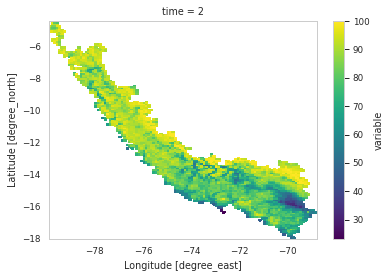

In [ ]:
CC_MASK_interpolated.variable[1,:,:].plot()

In [ ]:
#interpolate CC_MASK with PPM_MASK
WG_5MASK_WSR_interpolated=WG_5MASK_WSR.density.interp_like(PPM_MASK,method="nearest")
WG_5MASK_WSR_interpolated=WG_5MASK_WSR_interpolated.to_dataset()

In [ ]:
WG_5MASK_WSR

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 163, longitude: 133)
Coordinates:
  * longitude  (longitude) float64 -79.88 -79.79 -79.71 ... -69.04 -68.96 -68.88
  * latitude   (latitude) float64 -17.96 -17.88 -17.79 ... -4.625 -4.542 -4.458
  * time       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    density    (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.8
    title:        WWLLN Global Lightning Climatology, climatological mean (20...
    contact:      jed.kaplan@arve-research.com
    source_data:  WWLLN AE georeferenced stroke counts, corrected for detecti...
    node_offset:  1
    DOI:          https://doi.org/10.5281/zenodo.6007052

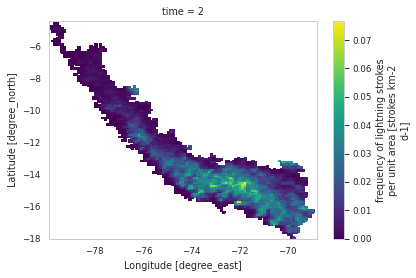

In [ ]:
WG_5MASK_WSR_interpolated.density[1,:,:].plot()

In [ ]:
def cor_point_grid2(x, y):
  res = pd.DataFrame({"x":x.ravel(),"y":y.ravel()})
  res = res.corr().to_numpy()[0,1]
  return res

In [ ]:
cor_field_field_space = xr.apply_ufunc(cor_point_grid2,
                                       WG_5MASK_WSR_interpolated.density,
                                       PPM_MASK_wsr,
                                       input_core_dims=[["latitude","longitude"], ["latitude","longitude"]], #e hace la correlacion por cada lugar en el espacio 
                                       vectorize=True)
cor_field_field_space

<xarray.DataArray (time: 12)>
array([0.44784228, 0.18662732, 0.06188413, 0.05559767, 0.23184227,
       0.77154966, 0.38001926, 0.34623001, 0.28675752, 0.34386347,
       0.61507248, 0.31958733])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

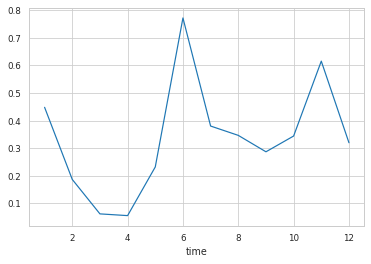

In [ ]:
cor_field_field_space.plot()

In [ ]:
cor_selva=cor_field_field_space.to_dataframe(name="Correlación")

MONTH = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
cor_selva["MONTH"]=MONTH
# cor_selva.drop("spatial_ref",axis=1,inplace=True)
cor_selva.to_csv("correlación_selva_pp_wgrc.csv")

cor_selva

,Correlación,MONTH
time,,
1,0.447842,Jan
2,0.186627,Feb
3,0.061884,March
4,0.055598,April
5,0.231842,May
6,0.771550,June
7,0.380019,July
8,0.346230,Aug
9,0.286758,Sept


In [ ]:
cor_field_field_space["time"]

<xarray.DataArray 'time' (time: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
cor_selva.describe()

,Correlación
count,12.000000
mean,0.337239
std,0.207101
min,0.055598
25%,0.220539
50%,0.331725
75%,0.396975
max,0.771550


(0.0, 0.8)

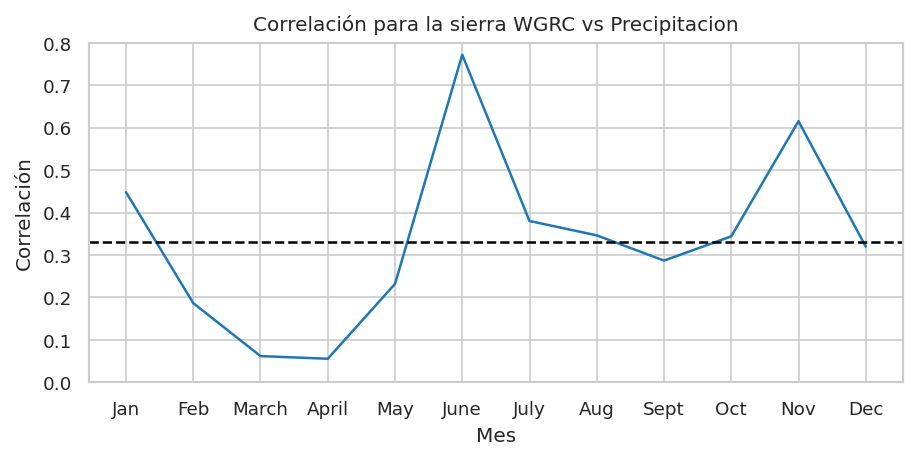

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 3), dpi = 150)

#contexto
sns.set_style("whitegrid")
sns.set_context("paper")

im = sns.lineplot(x="MONTH", y="Correlación", data=cor_selva)

ax.set_xlabel("Mes")

plt.axhline(0.33, color="k", linestyle="--")
ax.set_ylabel("Correlación")
ax.set_title("Correlación para la sierra WGRC vs Precipitacion")
ax.set_ylim([0, 0.8])


In [ ]:
import pandas as pd
import glob as glb
import datetime

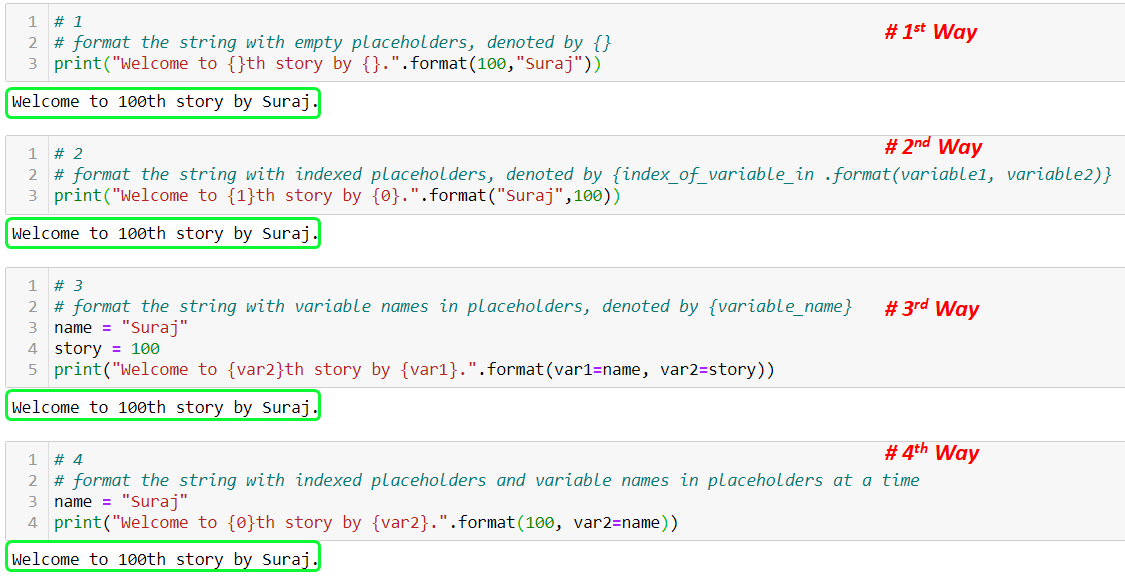

In [ ]:
cor_field_field_space = xr.apply_ufunc(cor_point_grid2,
                                       CC_MASK_interpolated.variable,
                                       PPM_MASK_wsr,
                                       input_core_dims=[["latitude","longitude"], ["latitude","longitude"]], #e hace la correlacion por cada lugar en el espacio 
                                       vectorize=True)
cor_field_field_space

<xarray.DataArray (time: 12)>
array([0.19294839, 0.15502513, 0.28215771, 0.44385335, 0.5949457 ,
       0.40032254, 0.45181407, 0.45442276, 0.49645853, 0.52612174,
       0.50301   , 0.38135278])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
cor_selva2=cor_field_field_space.to_dataframe(name="Correlación")
MONTH = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
cor_selva2["MONTH"]=MONTH
# cor_selva2.drop("spatial_ref",axis=1,inplace=True)
cor_selva2.to_csv("correlación_selva_pp_cc.csv")

cor_selva2

,Correlación,MONTH
time,,
1,0.192948,Jan
2,0.155025,Feb
3,0.282158,March
4,0.443853,April
5,0.594946,May
6,0.400323,June
7,0.451814,July
8,0.454423,Aug
9,0.496459,Sept


In [ ]:
cor_selva2.describe()

,Correlación
count,12.000000
mean,0.406869
std,0.134146
min,0.155025
25%,0.356554
50%,0.447834
75%,0.498096
max,0.594946


(0.0, 0.8)

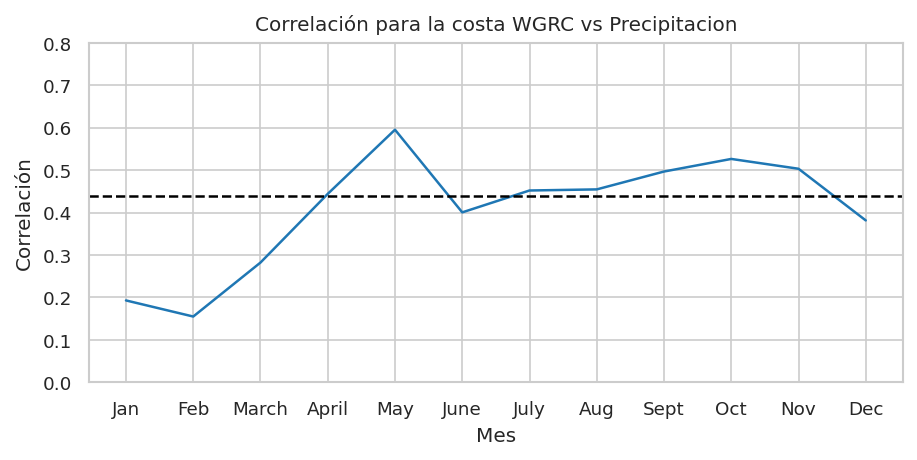

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 3), dpi = 150)

#contexto
sns.set_style("whitegrid")
sns.set_context("paper")

im = sns.lineplot(x="MONTH", y="Correlación", data=cor_sierra2)

ax.set_xlabel("Mes")

plt.axhline(0.44, color="k", linestyle="--")
ax.set_ylabel("Correlación")
ax.set_title("Correlación para la costa WGRC vs Precipitacion")
ax.set_ylim([0, 0.8])
